In [52]:
import os.path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [53]:
import warnings
warnings.simplefilter('ignore')

In [54]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [55]:
print(os.path.exists("../data/study_performance.csv"))

True


In [56]:
ds = pd.read_csv("../data/study_performance.csv")

In [57]:
print('columns count - ',len(ds.columns), '\n')
print('columns: ',list(ds.columns))

columns count -  8 

columns:  ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course', 'math_score', 'reading_score', 'writing_score']


## Data engineering

In [58]:
# Numerical data
numeric_columns = ds.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_columns:
    if ds[col].isnull().any():
        median_value = ds[col].mode()[0]
        ds[col].fillna(median_value, inplace=True)

In [59]:
ds.isnull().sum().sum()

0

In [60]:
# Categorical
categorical_columns = ds.select_dtypes(include=['object']).columns

map_dicts = dict()
for column in categorical_columns:
    ds[column] = ds[column].astype('category')
    map_dicts[column] = dict(zip(ds[column], ds[column].cat.codes))
    ds[column] = ds[column].cat.codes

In [61]:
ds.isnull().sum().sum()

0

# Modelling

## Regression

In [62]:
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split

from sklearn import metrics

In [63]:
# Let's predict  age

y_column = 'math_score'

X_columns = ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course','reading_score', 'writing_score']
X = ds[X_columns]
y = ds[y_column]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [65]:
models = {
    'LinearRegression' : LinearRegression(),
'LGBMRegressor' :LGBMRegressor(),
'SGDRegressor' :SGDRegressor(),
'RandomForestRegressor' :RandomForestRegressor(),
'ElasticNet' :ElasticNet(),
'BayesianRidge' :BayesianRidge(),
'GradientBoostingRegressor' :GradientBoostingRegressor(),
'SVR' :SVR(),
}

In [66]:
regressors = dict()
for name, model in models.items():
    print('training ',name)
    regressor = model
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    print(metrics.mean_absolute_error(y_test, y_pred))
    print(metrics.mean_absolute_percentage_error(y_test, y_pred))
    regressors[name] = regressor


training  LinearRegression
3.724803305843464
269538943803249.62
training  LGBMRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 900, number of used features: 7
[LightGBM] [Info] Start training from score 66.326667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
4.970959258510825
1154544717177826.5
training  SGDRegressor
4132112092701.669
5.871872402742022e+25
training  RandomForestRegressor
4.6986799999999995
697832762261058.4
training  ElasticNet
5.789088700597911
804932208978639.6
training  BayesianRidge
3.7232424484408373
273965667632177.47
training  GradientBoostingRegressor
4.414182418851632
581202420972165.2
training  SVR
7.991366858312685
2035680782177480.2


### Feature importances

In [67]:
# Get the coefficients from the Linear Regression model
coefficients = regressors['LinearRegression'].coef_

# Get the absolute values of coefficients to represent importance
abs_coefficients = np.abs(coefficients)

# Get the indices that would sort the absolute coefficients in descending order
indices = np.argsort(abs_coefficients)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_columns[indices[f]], abs_coefficients[indices[f]]))


Feature ranking:
1. gender (13.032917)
2. lunch (3.653310)
3. test_preparation_course (2.902741)
4. race_ethnicity (0.865138)
5. writing_score (0.611623)
6. reading_score (0.331159)
7. parental_level_of_education (0.145775)


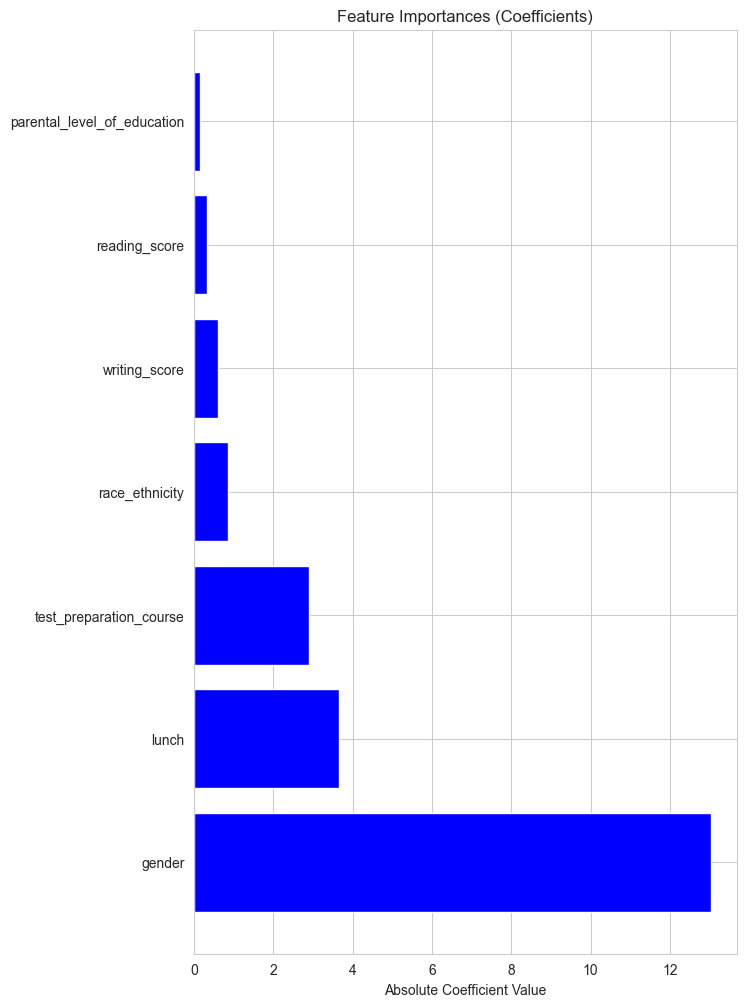

In [68]:
# Plot the feature importances (coefficients)
plt.figure(figsize=(7, 12))
plt.title('Feature Importances (Coefficients)')
plt.barh(range(len(indices)), abs_coefficients[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_columns[i] for i in indices])
plt.xlabel('Absolute Coefficient Value')
plt.show()